#### Hidden Markov Model and Market Regimes - ES E-mini S&P 500


####  Library Dependencies

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import warnings
import logging
import itertools
import matplotlib.pyplot as plt

from pyhhmm.gaussian import GaussianHMM
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Supress warning in hmmlearn
warnings.filterwarnings("ignore")

# Change plot style to ggplot for better visualization
plt.style.use('ggplot')


#### Futures Class

In [2]:
class FuturesProduct():
    def __init__(self, symbol, start_date, end_date):
        self.symbol = symbol
        self.start_date = start_date
        self.end_date = end_date
        self.get_data()
        self.log_returns()

    def get_data(self):
        futures = yf.download(self.symbol, self.start_date, self.end_date)
        futures.rename(columns = {"Adj Close" : "price"}, inplace = True)
        self.data = futures
        return futures
    
    def log_returns(self):
        self.data["log_returns"] = np.log(self.data.price / self.data.price.shift(1))  
        
    def plot_prices(self):
        self.data["Adj Close"].plot(figsize = (12,8), color = "blue")
        plt.title("Price Chart: {}".format(self.symbol), fontsize = 15) 
        

#### Instrument Observation

In [3]:
es = FuturesProduct("ES=F", "2017-01-01", "2022-12-31")

[*********************100%***********************]  1 of 1 completed


In [4]:
es.get_data()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,price,Volume
Date,,,,,,
2017-01-03 00:00:00-05:00,2240.75,2259.50,2239.50,2252.50,2252.50,1810351
2017-01-04 00:00:00-05:00,2252.75,2267.25,2251.00,2264.25,2264.25,1404875
2017-01-05 00:00:00-05:00,2264.50,2266.00,2254.00,2264.25,2264.25,1324035
2017-01-06 00:00:00-05:00,2264.25,2277.00,2258.25,2271.50,2271.50,1551007
2017-01-09 00:00:00-05:00,2271.25,2275.25,2263.50,2265.00,2265.00,1025182
...,...,...,...,...,...,...
2022-12-23 00:00:00-05:00,3850.00,3872.50,3821.25,3869.75,3869.75,1374913
2022-12-27 00:00:00-05:00,3878.00,3900.50,3837.25,3855.00,3855.00,1006414
2022-12-28 00:00:00-05:00,3858.00,3875.00,3804.50,3807.50,3807.50,1282810


In [5]:
es.log_returns()

<AxesSubplot: xlabel='Date'>

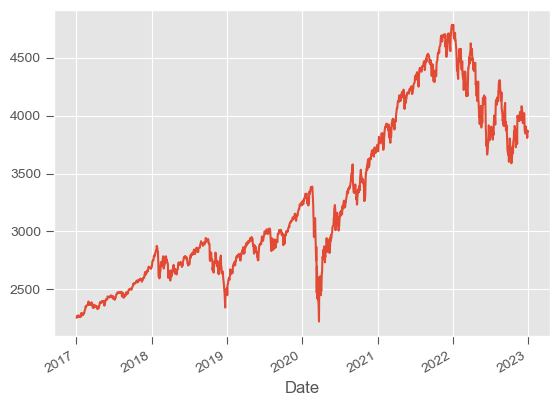

In [6]:
es.data.price.plot()

<AxesSubplot: xlabel='Date'>

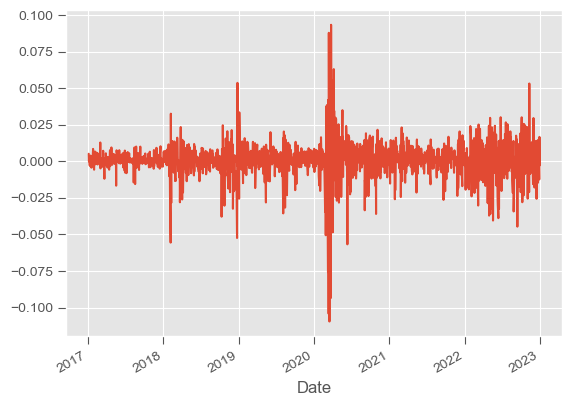

In [7]:
es.data.log_returns.plot()

<AxesSubplot: >

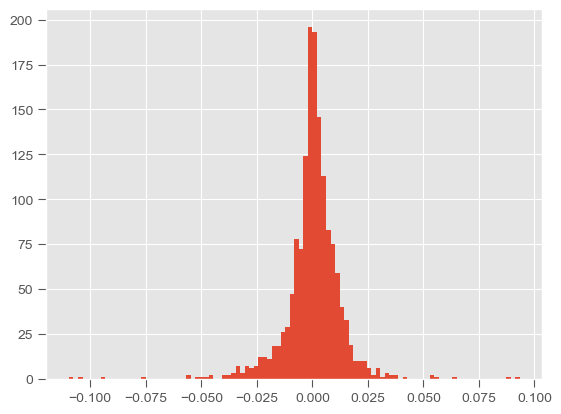

In [8]:
es.data.log_returns.hist(bins = 100)

#### Hidden Markov Model Learning

In [9]:
start_date = "2017-01-01"
end_date = "2022-12-31"
symbol = "ES=F"
futures = yf.download(symbol, start_date, end_date)
df = futures.copy()

[*********************100%***********************]  1 of 1 completed


In [10]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03 00:00:00-05:00,2240.75,2259.50,2239.50,2252.50,2252.50,1810351
2017-01-04 00:00:00-05:00,2252.75,2267.25,2251.00,2264.25,2264.25,1404875
2017-01-05 00:00:00-05:00,2264.50,2266.00,2254.00,2264.25,2264.25,1324035
2017-01-06 00:00:00-05:00,2264.25,2277.00,2258.25,2271.50,2271.50,1551007
2017-01-09 00:00:00-05:00,2271.25,2275.25,2263.50,2265.00,2265.00,1025182
...,...,...,...,...,...,...
2022-12-23 00:00:00-05:00,3850.00,3872.50,3821.25,3869.75,3869.75,1374913
2022-12-27 00:00:00-05:00,3878.00,3900.50,3837.25,3855.00,3855.00,1006414
2022-12-28 00:00:00-05:00,3858.00,3875.00,3804.50,3807.50,3807.50,1282810


In [11]:
df["Returns"] = (df["Adj Close"] / df["Adj Close"].shift(1)) - 1
df["Volatility"] = (df["High"] / df["Low"]) - 1
df.dropna(inplace = True)

In [12]:
df

,Open,High,Low,Close,Adj Close,Volume,Returns,Volatility
Date,,,,,,,,
2017-01-04 00:00:00-05:00,2252.75,2267.25,2251.00,2264.25,2264.25,1404875,0.005216,0.007219
2017-01-05 00:00:00-05:00,2264.50,2266.00,2254.00,2264.25,2264.25,1324035,0.000000,0.005324
2017-01-06 00:00:00-05:00,2264.25,2277.00,2258.25,2271.50,2271.50,1551007,0.003202,0.008303
2017-01-09 00:00:00-05:00,2271.25,2275.25,2263.50,2265.00,2265.00,1025182,-0.002862,0.005191
2017-01-10 00:00:00-05:00,2264.50,2274.00,2259.50,2263.75,2263.75,1304523,-0.000552,0.006417
...,...,...,...,...,...,...,...,...
2022-12-23 00:00:00-05:00,3850.00,3872.50,3821.25,3869.75,3869.75,1374913,0.005326,0.013412
2022-12-27 00:00:00-05:00,3878.00,3900.50,3837.25,3855.00,3855.00,1006414,-0.003812,0.016483
2022-12-28 00:00:00-05:00,3858.00,3875.00,3804.50,3807.50,3807.50,1282810,-0.012322,0.018531


In [13]:
# Features for training
X_train = df[["Returns", "Volatility"]]
X_train.head()

,Returns,Volatility
Date,,
2017-01-04 00:00:00-05:00,0.005216,0.007219
2017-01-05 00:00:00-05:00,0.000000,0.005324
2017-01-06 00:00:00-05:00,0.003202,0.008303
2017-01-09 00:00:00-05:00,-0.002862,0.005191
2017-01-10 00:00:00-05:00,-0.000552,0.006417


In [14]:
# Model Training
model = GaussianHMM(n_states=4, covariance_type='full', n_emissions=2)
model.train([np.array(X_train.values)])

(<pyhhmm.gaussian.GaussianHMM at 0x2382f34bcd0>, 10335.347902827856)

In [15]:
# Regime State preliminary observations
hidden_states = model.predict([X_train.values])[0]
print(hidden_states[:40])
len(hidden_states)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]


1511

In [16]:
# Regime State feature Means and Covariance 
model.means
model.covars

array([[[ 4.36183181e-05,  1.51886254e-05],
        [ 1.51886254e-05,  3.16665293e-05]],

       [[ 4.85436860e-04, -2.19653513e-04],
        [-2.19653513e-04,  4.02035206e-04]],

       [[ 2.35030122e-04,  8.08340091e-05],
        [ 8.08340091e-05,  1.05357855e-04]],

       [[ 1.46135406e-03,  1.10488001e-03],
        [ 1.10488001e-03,  1.16875702e-03]]])

In [17]:
# Regime State structure to be plotted
i = 0
regime_state_0 = []
regime_state_1 = []
regime_state_2 = []
regime_state_3 = []
prices = df["Adj Close"].values.astype(float)
print("Correct number of rows: ", len(prices) == len(hidden_states))
for s in hidden_states:
    if s == 0:
        regime_state_0.append(prices[i])
        regime_state_1.append(float('nan'))
        regime_state_2.append(float('nan'))
        regime_state_3.append(float('nan'))
    if s == 1:
        regime_state_0.append(float('nan'))
        regime_state_1.append(prices[i])
        regime_state_2.append(float('nan'))
        regime_state_3.append(float('nan'))
    if s == 2:
        regime_state_0.append(float('nan'))
        regime_state_1.append(float('nan'))
        regime_state_2.append(prices[i])
        regime_state_3.append(float('nan'))
    if s == 3:
        regime_state_0.append(float('nan'))
        regime_state_1.append(float('nan'))
        regime_state_2.append(float('nan'))
        regime_state_3.append(prices[i])
    i += 1

Correct number of rows:  True


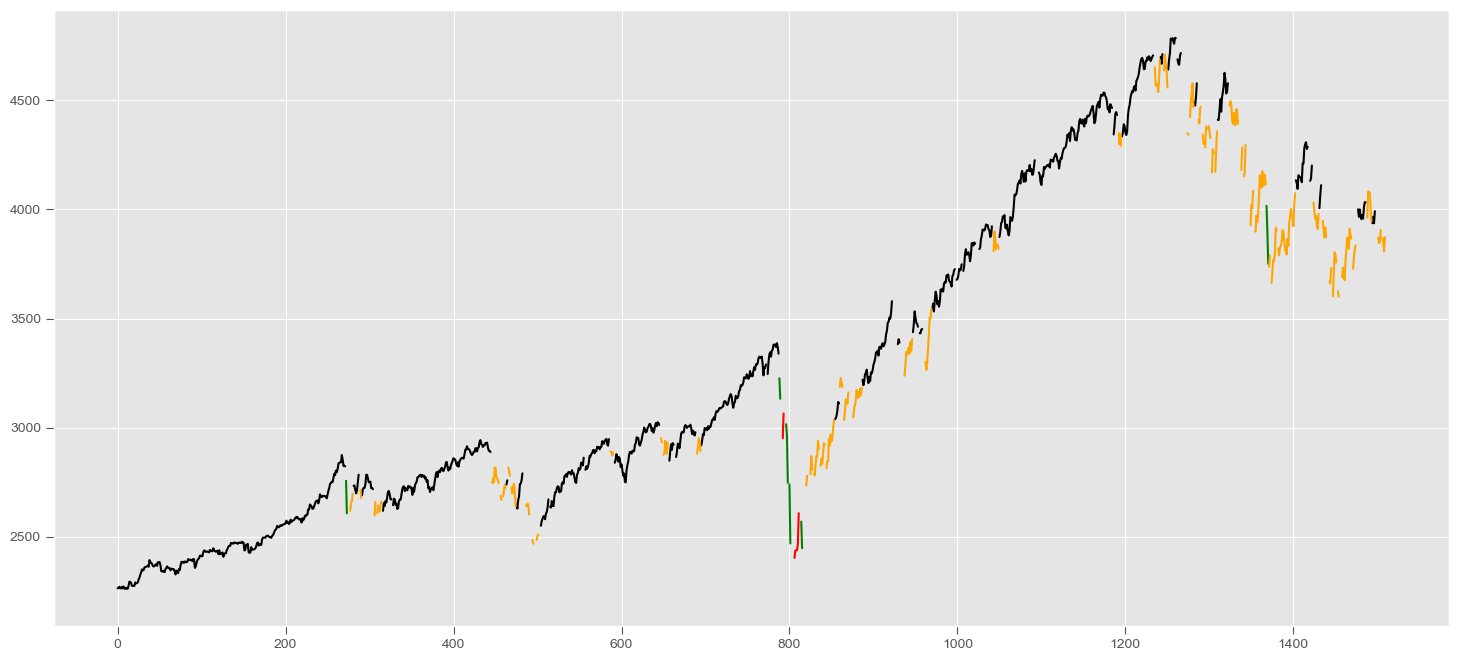

In [18]:
# Regime State Chart
fig = plt.figure(figsize= (18, 8))
plt.plot(regime_state_0, color="black")
plt.plot(regime_state_1, color="green")
plt.plot(regime_state_2, color="orange")
plt.plot(regime_state_3, color="red")
plt.show()

#### Observation

Hidden Markov Model has the ability to identify market regime states based on features selected in modeling, such as - Returns and Volatility.